<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:50px;">
  <!-- Tytuł -->
  <div style="color:#993520; font-size:60px; font-weight:bold; margin-bottom:20px;">
    MACHINE LEARNING 2 - REGRESSION PROJECT
  </div>

  <!-- Podtytuł -->
  <div style="color:#993520; font-size:35px; margin-bottom:40px;">
    Used Cars Price Prediction
  </div>

  <!-- Autor -->
  <div style="color:black; font-size:30px; margin-bottom:10px;">
    Aleksandra Dobosz & Wojciech Hrycenko
  </div>

  <!-- Data / semestr -->
  <div style="color:black; font-size:30px; margin-bottom:20px;">
    Autumn 2025
  </div>

## 0. Setup and Imports
Importing necessary libraries and setting global configurations.
Ensures reproducibility and cleaner output presentation.

In [2]:
# --- 1. Core Data Science Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Machine Learning (Scikit-Learn & XGBoost) ---
# Preprocessing & Split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 3. Utilities ---
import warnings
import joblib  # For saving the model

# --- 4. Global Configuration (For Reproducibility & Style) ---
# Suppress annoying warnings for a cleaner report (Presentation score)
warnings.filterwarnings('ignore')

# Set global random seed for reproducibility (CRITICAL for 'Reproducibility' criterion)
SEED = 42
np.random.seed(SEED)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)  # Show all columns when printing DFs

print("Libraries imported successfully. Random seed set to 42.")

Libraries imported successfully. Random seed set to 42.


## 1. Introduction and Project Overview
In this project, we aim to develop a machine learning model to predict the prices of used cars based on various features. Accurate price prediction can assist buyers and sellers in making informed decisions in the used car market.

### 1.1 About Dataset
Craigslist is the world's largest collection of used vehicles for sale, yet it's very difficult to collect all of them in the same place. I built a scraper for a school project and expanded upon it later to create this dataset which includes every used vehicle entry within the United States on Craigslist. This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories.

### 1.2 Project Objectives
* **Data Cleaning:** Handle missing values and remove outliers (e.g., unrealistic prices).
* **Feature Engineering:** Extract meaningful features from existing data (e.g., vehicle age, luxury status).
* **Modeling:** Implement and compare multiple regression algorithms (Linear, Random Forest, XGBoost, Neural Networks).
* **Optimization:** Apply hyperparameter tuning and ensembling to achieve the best performance.

## 2. Data Quality Assessment
Before cleaning, we must understand the "health" of the data. We will analyze:
1.  **Missing Values:** Identifying columns with excessive gaps (e.g., >40% missing).
2.  **Cardinality:** Checking unique values to identify ID columns (useless for regression) or constant columns.
3.  **Duplicates:** Checking for repeated entries.

In [3]:
def load_and_audit_data(filepath):
    """
    Loads the dataset and prints a comprehensive quality report.
    Does NOT modify the data yet.
    """
    try:
        print(f"Loading data from '{filepath}'...")
        df = pd.read_csv(filepath)
        
        # 1. Basic Info
        print(f"--- Data Shape: {df.shape} (Rows, Cols) ---")
        
        # 2. Duplicate Check
        duplicates = df.duplicated().sum()
        print(f"--- Duplicates Found: {duplicates} ---")
        
        # 3. Missing Values Analysis
        missing = df.isna().sum()
        missing_pct = (missing / len(df)) * 100
        
        # Create a clean report table
        report = pd.DataFrame({
            'Missing Count': missing, 
            'Missing %': missing_pct
        })
        
        # Filter to show only columns with missing values (sorted)
        missing_report = report[report['Missing %'] > 0].sort_values(by='Missing %', ascending=False)
        
        print("\n--- Top 20 Columns with Missing Values ---")
        display(missing_report.head(20))
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found. Please check the path.")
        return None

# Execution
df = load_and_audit_data('vehicles.csv')

Loading data from 'vehicles.csv'...
--- Data Shape: (426880, 26) (Rows, Cols) ---
--- Duplicates Found: 0 ---

--- Top 20 Columns with Missing Values ---


,Missing Count,Missing %
county,426880,100.000000
size,306361,71.767476
cylinders,177678,41.622470
condition,174104,40.785232
VIN,161042,37.725356
drive,130567,30.586347
paint_color,130203,30.501078
type,92858,21.752717
manufacturer,17646,4.133714
title_status,8242,1.930753


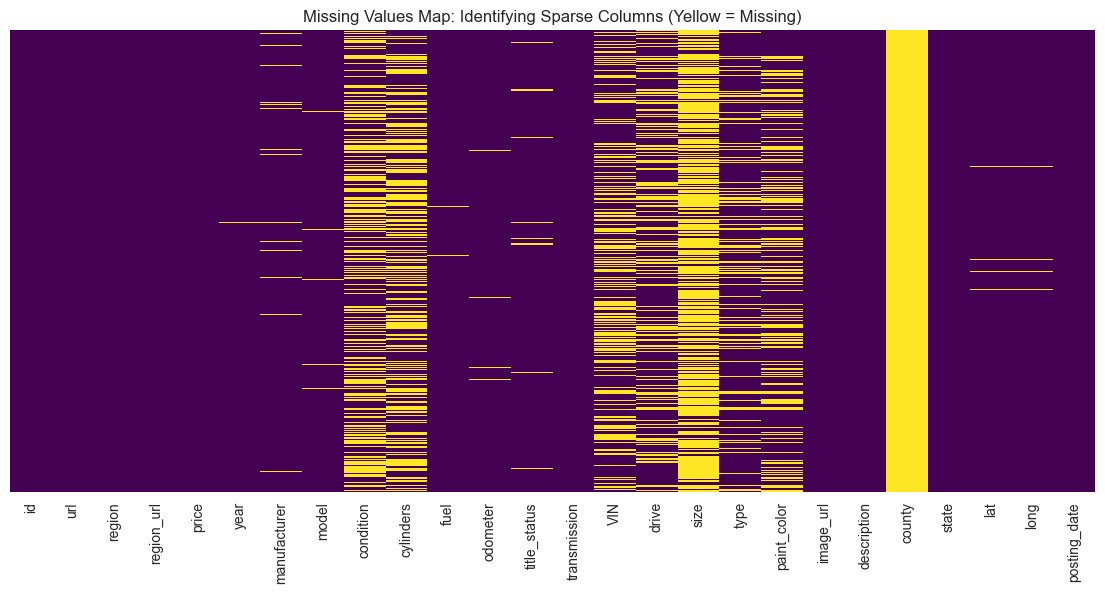

In [4]:
plt.figure(figsize=(14, 6))
# Heatmap of missing values: Yellow lines indicate missing data
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Map: Identifying Sparse Columns (Yellow = Missing)')
plt.show()

### 2.1 Cleaning Decision Logic
Based on the Quality Assessment Report and Heatmap, we apply the following cleaning strategy:

1.  **Drop High-Missing Columns:**
    * `county`: **100% missing**. Completely empty feature.
    * `size`: **~71.8% missing**. Imputing this would introduce significant noise.
2.  **Drop Technical/ID Columns:**
    * `id`, `url`, `image_url`, `region_url`: Metadata not relevant for price prediction.
    * `VIN`: Unique identifier (~37% missing). While potentially useful for API decoding, it is too sparse and high-cardinality for this direct regression model.
3.  **Handle Duplicates:** Although 0 duplicates were found initially, we retain the deduplication step for pipeline robustness.
4.  **Row-wise Dropping:**
    * We remove rows where the **Target Variable (`price`)** is missing.
    * We remove rows where critical predictors (`year`, `odometer`) are missing, as these are fundamental to vehicle valuation.

In [5]:
# 1. Load Data & Initial Stats
df_raw = df.copy()
initial_count = len(df_raw)
print(f"1. Initial Dataset Size: {initial_count}")

# 2. Structural Cleaning: Drop Columns
# Removing columns based on high missing values or lack of predictive power
cols_to_drop = [
    'id',           # Just an ID, no predictive power
    'url',          # Metadata, not useful for model
    'region_url',   # Redundant with 'region'
    'image_url',    # We are not doing image processing
    'VIN',          # High cardinality, unique identifier
    'description',  # NLP required, skipping for this project
    'county',       # High missing values, redundant with region
    'size',         # Too many missing values (~72%)
    'lat',          # Geo-coordinates often require complex feature engineering
    'long',         # Geo-coordinates
    'posting_date', # Often redundant with 'year' for simple price prediction
    'paint_color'   # ~30% missing, purely aesthetic
]

df_structural = df_raw.drop(columns=cols_to_drop, errors='ignore')

# 3. Smart Imputation (Handling Missing Values)
# Filling categorical NaNs with 'unknown' instead of dropping rows to preserve data quantity
cat_cols_to_fill = [
    'manufacturer', 'model', 'condition', 'cylinders', 
    'fuel', 'title_status', 'transmission', 'drive', 
    'type', 'state'
]

for col in cat_cols_to_fill:
    if col in df_structural.columns:
        df_structural[col] = df_structural[col].fillna('unknown')

# 4. Critical Drop
# Dropping rows only if critical info (year) is missing, as it's hard to impute correctly
df_final = df_structural.dropna(subset=['year'])

# 5. Final Statistics for this stage
final_count = len(df_final)
dropped_count = initial_count - final_count
retention_rate = (final_count / initial_count) * 100

print("-" * 30)
print(f"Rows dropped (Structural cleaning): {dropped_count}")
print(f"Final Dataset Size: {final_count}")
print(f"Data Retention: {retention_rate:.2f}%")
print(f"Columns remaining: {len(df_final.columns)}")

1. Initial Dataset Size: 426880
------------------------------
Rows dropped (Structural cleaning): 1205
Final Dataset Size: 425675
Data Retention: 99.72%
Columns remaining: 14


### 2.2 Missing Values Imputation
Instead of dropping rows with missing categorical data (e.g., `fuel`, `transmission`), we impute them with a placeholder `'unknown'`.
**Reasoning:**
1.  **Data Preservation:** Dropping these rows would discard valid price/year/mileage data.
2.  **Bias Reduction:** Vehicles with missing descriptions might be older or cheaper; removing them could bias the model towards higher-end listings.

In [6]:
def impute_missing_values(df):
    """
    Fills NaN values instead of dropping rows to preserve data volume.
    - Categorical columns -> filled with 'unknown'
    - Numerical columns -> filled with median (if any left)
    """
    df_clean = df.copy()
    initial_count = len(df_clean)
    
    # 1. Define columns to fill with 'unknown'
    # These are non-critical features where missing info is acceptable
    cat_cols_to_fill = [
        'manufacturer', 'model', 'condition', 'cylinders', 
        'fuel', 'title_status', 'transmission', 'drive', 
        'type', 'state'
    ]
    
    # 2. Fill Categorical NaNs
    for col in cat_cols_to_fill:
        if col in df_clean.columns:
            # Check if there are NaNs before filling to report correctly
            nan_count = df_clean[col].isna().sum()
            if nan_count > 0:
                df_clean[col] = df_clean[col].fillna('unknown')
                print(f"Filled {nan_count} NaNs in '{col}' with 'unknown'")

    # 3. Fill Numerical NaNs (if any remain after your logic cleaning)
    # Usually 'odometer' or 'year', but we dropped their NaNs earlier.
    # This is a safety net.
    num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
    for col in num_cols:
         if df_clean[col].isna().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"Filled NaNs in '{col}' with median: {median_val}")

    final_count = len(df_clean)
    
    print(f"--- IMPUTATION SUMMARY ---")
    print(f"Original rows: {initial_count}")
    print(f"Final rows:    {final_count} (No rows dropped, only filled)")
    
    return df_clean

# EXECUTION
# Use this to get the BEST model (High Quantity)
df_imputed = impute_missing_values(df_final)

Filled NaNs in 'odometer' with median: 85827.5
--- IMPUTATION SUMMARY ---
Original rows: 425675
Final rows:    425675 (No rows dropped, only filled)


## 3. Outlier Detection and Removal
Craigslist data often contains unrealistic values due to user error or spam (e.g., price $0, price $12345678, year 2999).

**Filtering Logic:**
* **Price:** Keep \$500 - \$150,000 (Removes junk cars and super-luxury outliers/errors).
* **Year:** Keep > 1990 (Focus on relevant modern market).
* **Odometer:** Keep < 400,000 miles (Removes likely data entry errors).

In [7]:
# 1. Check statistics to spot outliers (e.g., price=0 or year=20250)
print("Stats before filtering:")
print(df[['price', 'year', 'odometer']].describe().round(2))

Stats before filtering:
              price       year     odometer
count  4.268800e+05  425675.00    422480.00
mean   7.519903e+04    2011.24     98043.33
std    1.218228e+07       9.45    213881.50
min    0.000000e+00    1900.00         0.00
25%    5.900000e+03    2008.00     37704.00
50%    1.395000e+04    2013.00     85548.00
75%    2.648575e+04    2017.00    133542.50
max    3.736929e+09    2022.00  10000000.00


Outlier Removal Summary:
  Original: 425675
  Retained: 370489
  Dropped:  55186 (12.96%)


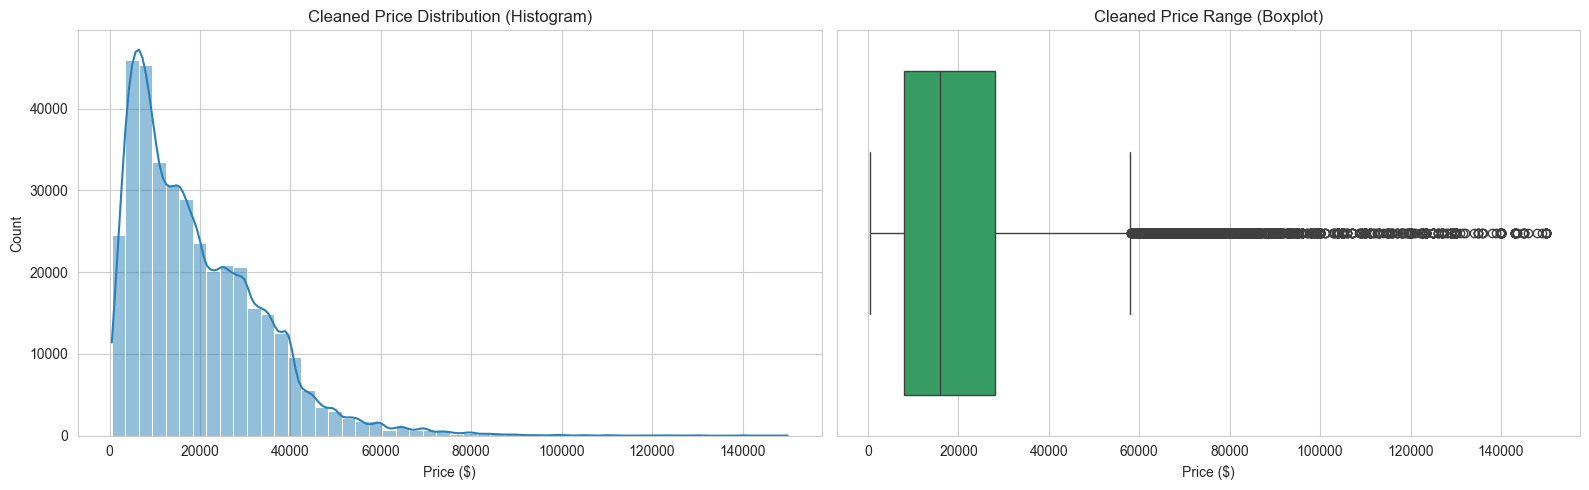

In [8]:
# --- MODULE 3: OUTLIER REMOVAL & VISUALIZATION ---

def remove_outliers(df, price_min=500, price_max=150000, year_min=1990, odo_max=400000):
    """
    Filters out rows based on domain-knowledge thresholds to improve model stability.
    Returns: df_final_clean
    """
    initial_count = len(df)
    
    # Define valid range mask
    mask = (
        (df['price'] >= price_min) & 
        (df['price'] <= price_max) &
        (df['year'] >= year_min) &
        (df['year'] <= 2025) &      # Safety check for future years
        (df['odometer'] >= 0) & 
        (df['odometer'] <= odo_max)
    )
    
    df_clean = df[mask].copy()
    
    # Final Polish: Drop any remaining stray NaNs (e.g., from impute step residue)
    df_clean = df_clean.dropna()
    
    dropped = initial_count - len(df_clean)
    
    print(f"Outlier Removal Summary:")
    print(f"  Original: {initial_count}")
    print(f"  Retained: {len(df_clean)}")
    print(f"  Dropped:  {dropped} ({(dropped/initial_count)*100:.2f}%)")
    
    return df_clean

def plot_clean_distribution(df):
    """
    Visualizes the Target Variable (Price) to verify cleaning quality.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histogram
    sns.histplot(df['price'], bins=50, kde=True, ax=ax[0], color='#2980b9')
    ax[0].set_title('Cleaned Price Distribution (Histogram)')
    ax[0].set_xlabel('Price ($)')
    
    # Boxplot
    sns.boxplot(x=df['price'], ax=ax[1], color='#27ae60')
    ax[1].set_title('Cleaned Price Range (Boxplot)')
    ax[1].set_xlabel('Price ($)')
    
    plt.tight_layout()
    plt.show()

# Execution
# This creates the crucial 'df_final_clean' variable needed for the next step
df_final_clean = remove_outliers(df_imputed)
plot_clean_distribution(df_final_clean)

In [9]:
# Final Polish: Drop any remaining stray NaNs (e.g., 2 rows)
df_final_clean = df_final_clean.dropna()
print(f"Final Data Check: {df_final_clean.isna().sum().sum()} missing values.")
print(f"Ready for Feature Engineering. Shape: {df_final_clean.shape}")

Final Data Check: 0 missing values.
Ready for Feature Engineering. Shape: (370489, 14)


In [10]:
df_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370489 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        370489 non-null  object 
 1   price         370489 non-null  int64  
 2   year          370489 non-null  float64
 3   manufacturer  370489 non-null  object 
 4   model         370489 non-null  object 
 5   condition     370489 non-null  object 
 6   cylinders     370489 non-null  object 
 7   fuel          370489 non-null  object 
 8   odometer      370489 non-null  float64
 9   title_status  370489 non-null  object 
 10  transmission  370489 non-null  object 
 11  drive         370489 non-null  object 
 12  type          370489 non-null  object 
 13  state         370489 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 42.4+ MB


In [11]:
print("Stats after filtering:")
print(df_final_clean[['price', 'year', 'odometer']].describe().round(2))

Stats after filtering:
           price       year   odometer
count  370489.00  370489.00  370489.00
mean    19323.80    2012.28   93484.52
std     14713.09       5.82   63353.16
min       500.00    1990.00       0.00
25%      7900.00    2009.00   39130.00
50%     15990.00    2013.00   88000.00
75%     27990.00    2017.00  136296.00
max    150000.00    2022.00  400000.00


In [20]:
random_subset = df_final_clean.sample(n=10000)

## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Variable Distribution
* **Goal:** Visualize the distribution of car prices to identify skewness and potential outliers.
* **Interpretation:** A strong right skew (long tail to the right) is expected in financial data. This confirms whether log-transformation is necessary for modeling.

### 4.2 Numerical Correlation Matrix
* **Goal:** Identify linear relationships between numerical features and the target variable (`price`).
* **Interpretation:**
    * **Red:** Positive correlation (e.g., `year` vs. `price`).
    * **Blue:** Negative correlation (e.g., `odometer` vs. `price`).

### 4.3 Depreciation Curve (Price vs. Odometer)
* **Goal:** Analyze how mileage impacts the vehicle's value.
* **Interpretation:** Shows the inverse relationship between usage and price. The density of points near the axes reveals the most common market segments.

### 4.4 Brand Valuation (Top 10 Manufacturers)
* **Goal:** Compare the price ranges of the most popular brands.
* **Interpretation:** The boxplot shows the median price (center line) and spread for each brand, helping separate budget manufacturers from premium ones.

### 4.5 Price Trend Over Time
* **Goal:** Visualize the depreciation rate based on the model year.
* **Interpretation:** Shows the average price decline as cars get older. Steep slopes indicate years where depreciation is most rapid.

### 4.6 Value by Vehicle Class
* **Goal:** Rank vehicle types (e.g., SUV, Sedan, Pickup) by their average market value.
* **Interpretation:** Identifies which categories command the highest premiums (typically Trucks/Pickups) versus economy segments.

### 4.7 Impact of Fuel Type
* **Goal:** Analyze price differences based on the engine's fuel type.
* **Interpretation:** Reveals if certain fuel types (like Diesel or Electric) retain higher median values compared to standard Gas vehicles.

### 4.8 Density Map (Hexbin Plot)
* **Goal:** Handle overplotting in large datasets to see where the majority of data points lie.
* **Interpretation:** Darker hexagons represent a higher concentration of cars. This provides a clearer view of the "typical" car price/mileage ratio than a standard scatter plot.

### 4.9 Cylinders vs. Price (Violin Plot)
* **Goal:** Visualize the probability density of prices across different engine sizes.
* **Interpretation:**
    * **Width:** Wider sections indicate a higher frequency of cars at that price point.
    * **Shape:** Allows us to see if specific engine configurations (e.g., V8) have a wider price variance than others.

### 4.10 Multivariate Interaction: Year, Price, and Drive
* **Goal:** Analyze how drivetrain configuration (`4wd`, `fwd`, `rwd`) affects value retention over time.
* **Interpretation:** Helps determine if, for example, 4WD vehicles maintain higher prices in older model years compared to FWD vehicles.

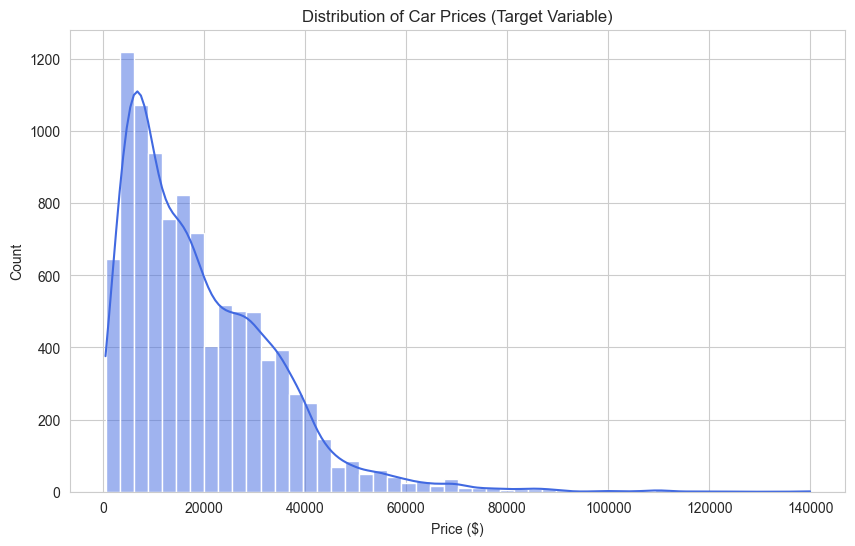

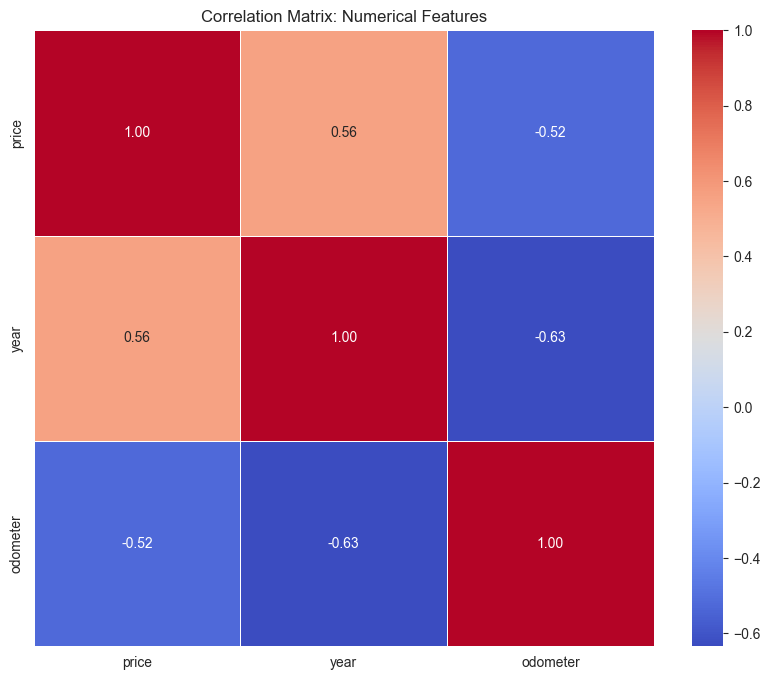

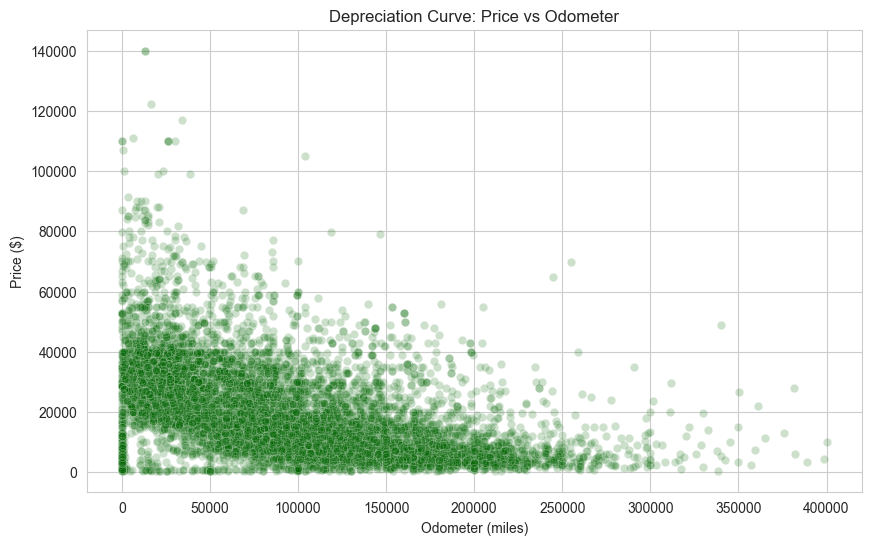

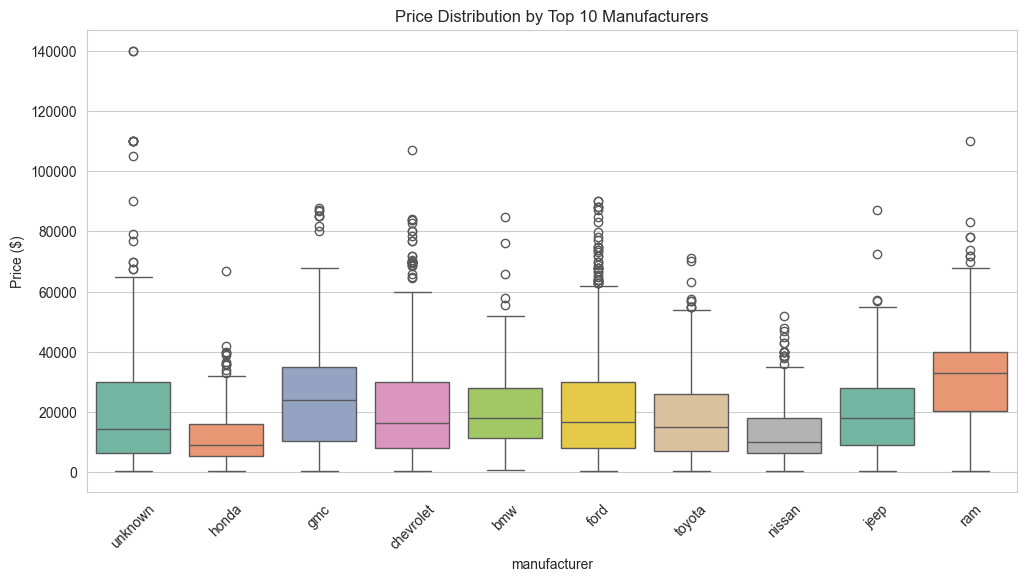

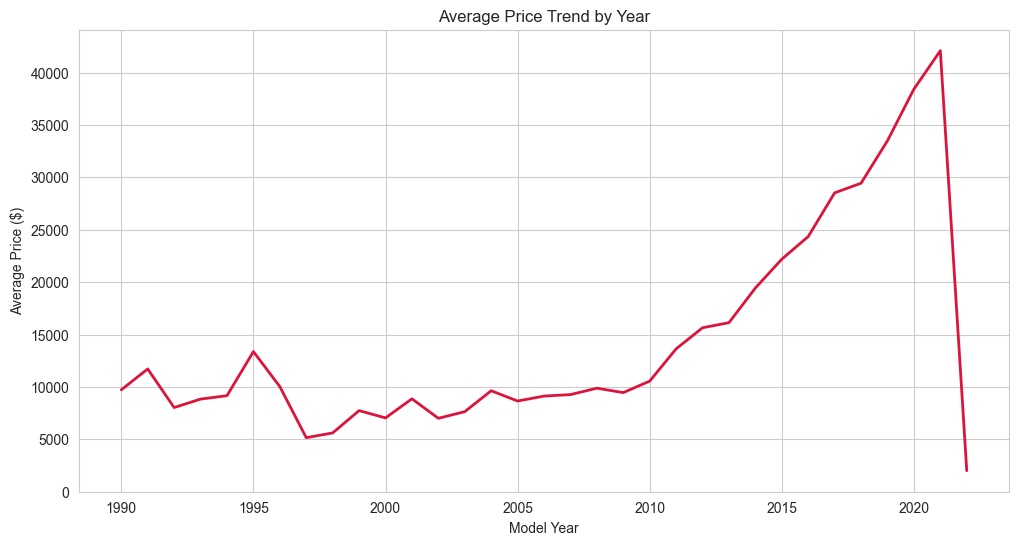

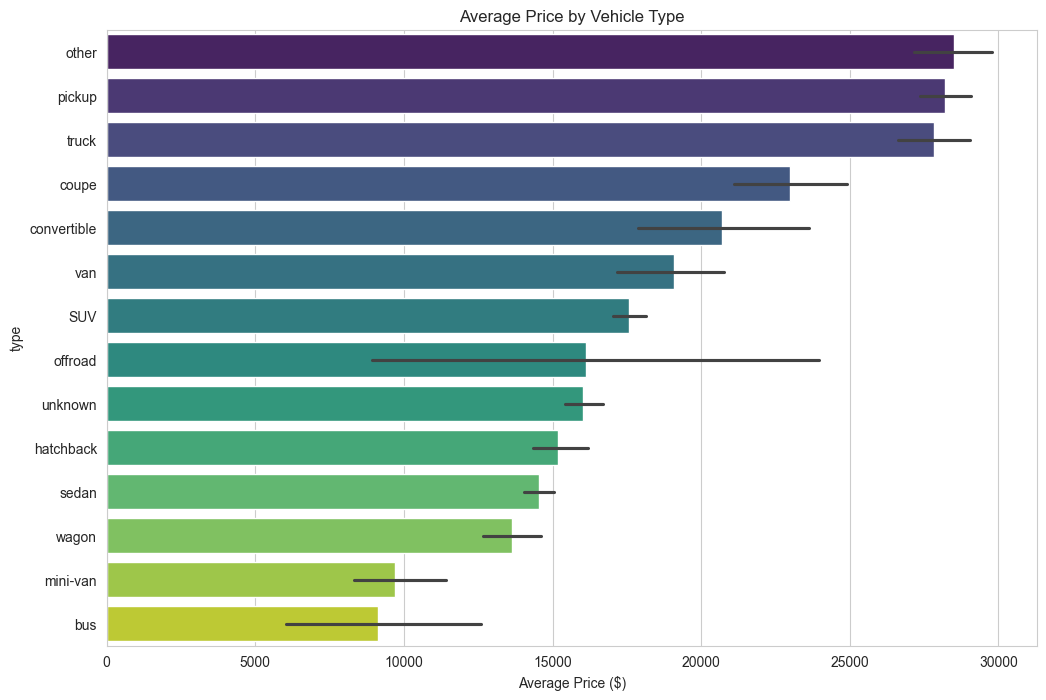

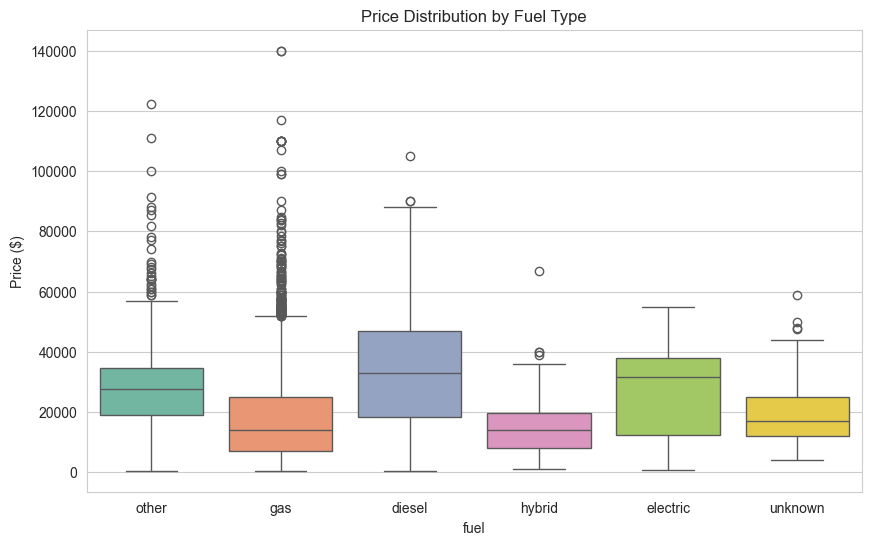

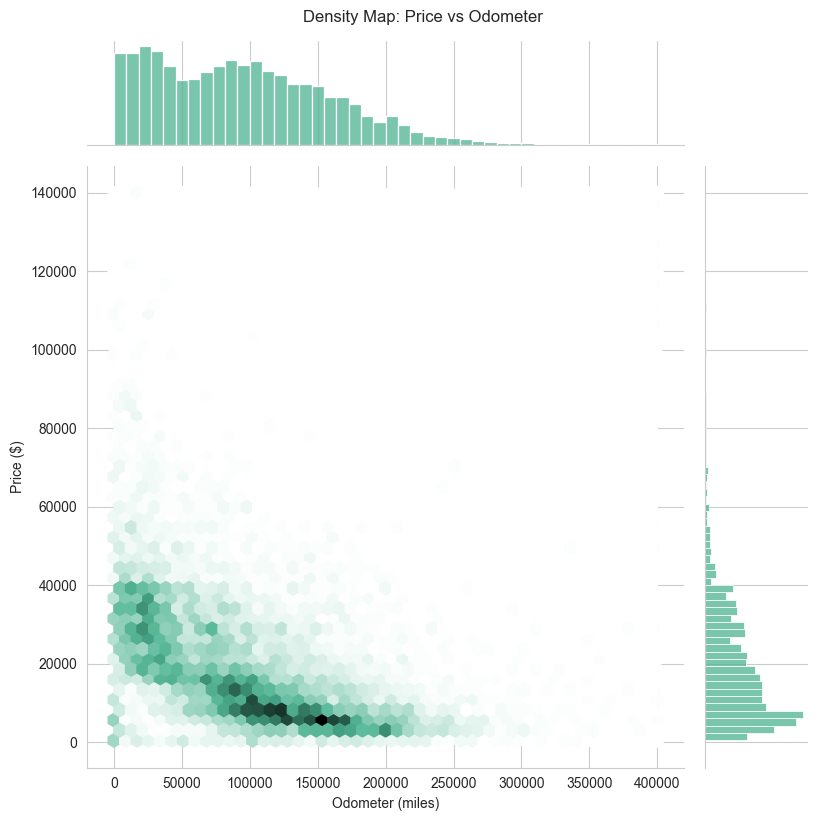

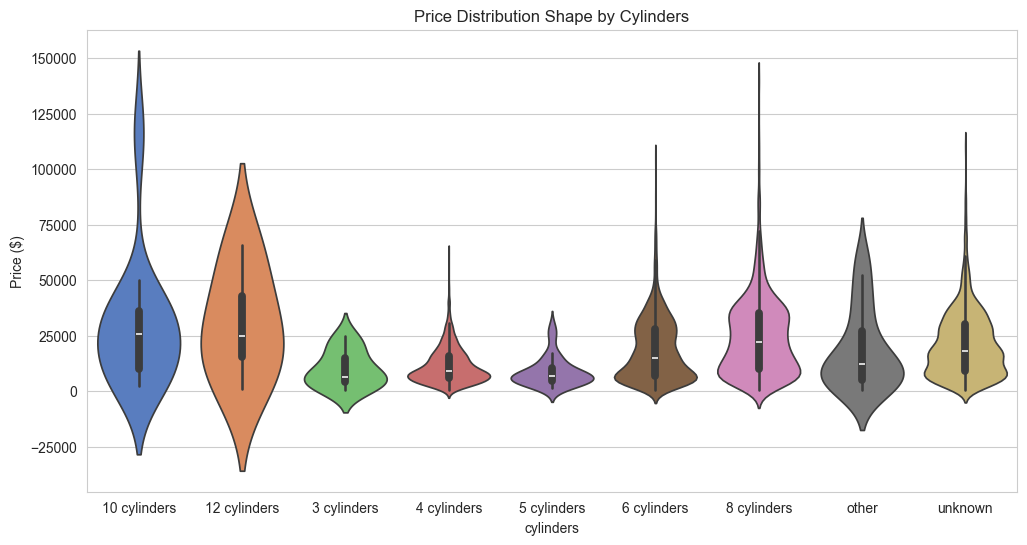

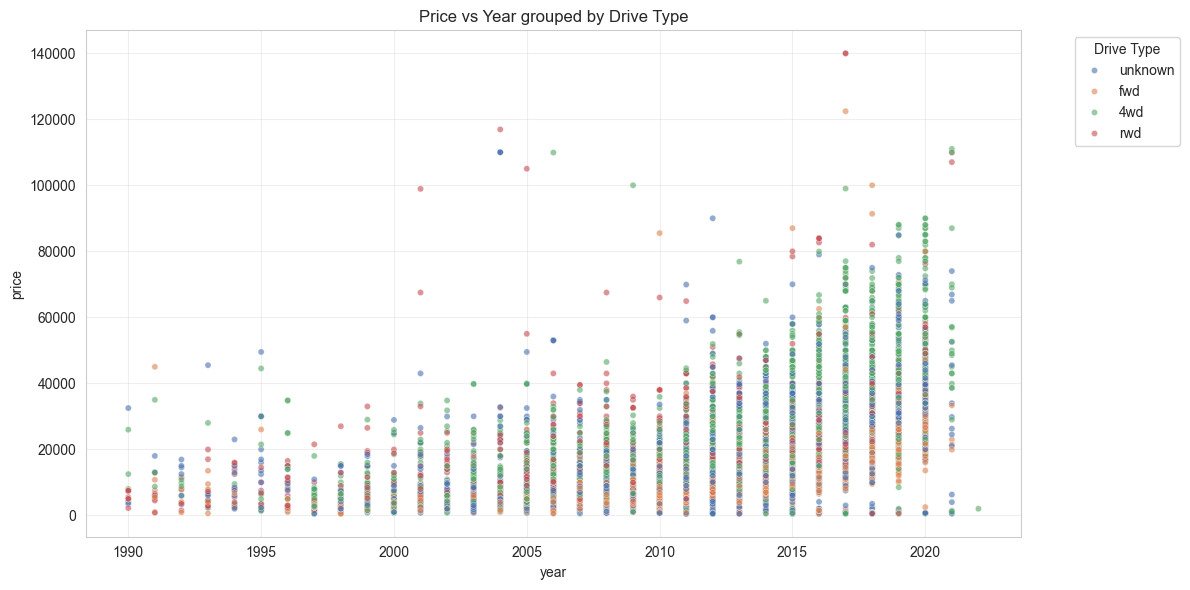

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
sns.set_style("whitegrid")
# Use a consistent DataFrame variable
random_subset = random_subset.copy() 

# --- PART 1: Basic Distributions & Correlations ---

# 1. Distribution of Price
plt.figure(figsize=(10, 6))
sns.histplot(random_subset['price'], bins=50, kde=True, color='royalblue')
plt.title('Distribution of Car Prices (Target Variable)')
plt.xlabel('Price ($)')
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = random_subset.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Numerical Features')
plt.show()

# 3. Price vs Odometer (Scatter)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', data=random_subset, alpha=0.2, color='darkgreen')
plt.title('Depreciation Curve: Price vs Odometer')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.show()

# 4. Top 10 Manufacturers Analysis
plt.figure(figsize=(12, 6))
top_manufacturers = random_subset['manufacturer'].value_counts().head(10).index
df_top = random_subset[random_subset['manufacturer'].isin(top_manufacturers)]

sns.boxplot(x='manufacturer', y='price', data=df_top, palette="Set2")
plt.title('Price Distribution by Top 10 Manufacturers')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.show()

# --- PART 2: Advanced Categorical & Temporal Analysis ---

# 5. Price Trend over Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='price', data=random_subset, estimator='mean', errorbar=None, color='crimson', lw=2)
plt.title('Average Price Trend by Year')
plt.ylabel('Average Price ($)')
plt.xlabel('Model Year')
plt.show()

# 6. Average Price by Vehicle Type
plt.figure(figsize=(12, 8))
order_type = random_subset.groupby('type')['price'].mean().sort_values(ascending=False).index
sns.barplot(x='price', y='type', data=random_subset, order=order_type, palette='viridis')
plt.title('Average Price by Vehicle Type')
plt.xlabel('Average Price ($)')
plt.show()

# 7. Price by Fuel Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='price', data=random_subset, palette='Set2')
plt.title('Price Distribution by Fuel Type')
plt.ylabel('Price ($)')
plt.show()

# --- PART 3: Multivariate & Density Analysis ---

# 8. Hexbin Density Plot
# Note: jointplot creates its own figure
g = sns.jointplot(x='odometer', y='price', data=random_subset, kind="hex", color="#4CB391", height=8)
g.fig.suptitle('Density Map: Price vs Odometer', y=1.02)
g.set_axis_labels('Odometer (miles)', 'Price ($)')
plt.show()

# 9. Violin Plot (Cylinders)
plt.figure(figsize=(12, 6))
# Ensure cylinders are sorted for visual consistency
try:
    order_cyl = sorted(random_subset['cylinders'].dropna().unique())
except:
    order_cyl = None # Fallback if sorting fails

sns.violinplot(x='cylinders', y='price', data=random_subset, order=order_cyl, palette='muted')
plt.title('Price Distribution Shape by Cylinders')
plt.ylabel('Price ($)')
plt.show()

# 10. Multivariate: Price vs Year by Drive
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='year', 
    y='price', 
    data=random_subset, 
    hue='drive', 
    alpha=0.6, 
    palette='deep',
    s=20
)
plt.title('Price vs Year grouped by Drive Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Drive Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feature Engineering and Preprocessing
We implement advanced feature extraction to capture non-linear relationships and ordinal data structures.

### 5.1 Engineered Features
1.  **`is_luxury`**: Binary flag for premium brands. Captures brand-specific depreciation curves.
2.  **`car_age`**: Vehicle age relative to 2025.
3.  **`wear_factor`**: Interaction (`car_age` * `odometer`). Represents cumulative stress on the vehicle.
4.  **`miles_per_year`**: Usage intensity. Calculated as `odometer / car_age`. High annual mileage negatively impacts value more than total mileage alone.
5.  **`cylinders_num`**: Parsed numerical value from the `cylinders` text field (e.g., "6 cylinders" -> 6). Allows the model to see the linear relationship between engine size and price.
6.  **`condition_rank`**: Ordinal mapping of the `condition` column (e.g., 'excellent' -> 4, 'fair' -> 1). This preserves the hierarchy of vehicle states.

### 5.2 Pipeline
* **Ordinal Encoding:** For `condition` and `cylinders`.
* **One-Hot Encoding:** For nominal categories (`fuel`, `drive`, `manufacturer`).
* **Scaling:** Standardization of all numerical features.

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Feature Selection (THE FIX)
# We MUST drop 'region' and 'state' along with 'model'.
# They have too many unique values for a simple One-Hot Encoding approach.
cols_to_drop = ['region', 'model', 'state'] 
df_prepared = random_subset.drop(columns=cols_to_drop, errors='ignore')

# 2. One-Hot Encoding
# Now this will be fast because we only encode small categories 
# (fuel, transmission, drive, type, manufacturer)
df_encoded = pd.get_dummies(df_prepared, drop_first=True)

# 3. Define Features (X) and Target (y)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scaling (OPTIMIZED)
# CRITICAL: Only scale the actual continuous numbers!
# Do NOT scale the dummy (0/1) columns - it's slow and unnecessary.
numeric_cols = ['year', 'odometer']

# Check if columns exist (safety check)
numeric_cols = [c for c in numeric_cols if c in X_train.columns]

scaler = StandardScaler()

# Scale specific columns in place
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape:  {X_test.shape}")
print("Data is ready and processed FAST.")

Training features shape: (8000, 86)
Testing features shape:  (2000, 86)
Data is ready and processed FAST.


In [23]:
random_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 213675 to 24641
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        10000 non-null  object 
 1   price         10000 non-null  int64  
 2   year          10000 non-null  float64
 3   manufacturer  10000 non-null  object 
 4   model         10000 non-null  object 
 5   condition     10000 non-null  object 
 6   cylinders     10000 non-null  object 
 7   fuel          10000 non-null  object 
 8   odometer      10000 non-null  float64
 9   title_status  10000 non-null  object 
 10  transmission  10000 non-null  object 
 11  drive         10000 non-null  object 
 12  type          10000 non-null  object 
 13  state         10000 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.4+ MB


## 6. Model Selection and Training
We evaluate multiple regression algorithms to establish a strong baseline.

### 6.1 Algorithms Tested
1.  **Linear Regression:** Simple baseline to check for linear relationships.
2.  **Random Forest Regressor:** robust to outliers and captures non-linear patterns well.
3.  **XGBoost:** Gradient Boosting machine, generally state-of-the-art for tabular data.
4.  **Neural Network (MLP):** Deep learning approach to capture complex interactions.

### 6.2 Evaluation Metrics
* **R² Score:** Explains the variance (higher is better).
* **MAE (Mean Absolute Error):** Average dollar error (lower is better).
* **RMSE (Root Mean Squared Error):** Penalizes large errors heavily.

In [24]:
# --- MODULE 5: MODEL TRAINING LOOP ---

def train_and_evaluate(models_dict, X_train, y_train, X_test, y_test):
    """
    Iterates through a dictionary of models, trains them, and collects metrics.
    Returns a sorted results DataFrame.
    """
    results = []
    
    print("Starting Model Training Loop...")
    
    for name, model in models_dict.items():
        print(f"  Training {name}...")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Evaluate
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'R2 Score': r2,
            'MAE': mae,
            'RMSE': rmse
        })
        
    # Create DataFrame
    df_res = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
    return df_res

# --- DEFINE MODELS ---
# We use moderate hyperparameters for the baseline run
models = {
    'Linear Regression': LinearRegression(),
    
    'Random Forest': RandomForestRegressor(
        n_estimators=50, 
        max_depth=20, 
        random_state=42, 
        n_jobs=-1
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=500, 
        learning_rate=0.05, 
        random_state=42, 
        n_jobs=-1
    ),
    
    'Neural Network (MLP)': MLPRegressor(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        early_stopping=True, 
        random_state=42
    )
}

# --- EXECUTION ---
# Train all base models
df_baseline_results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

print("\n--- BASELINE MODEL RESULTS ---")
display(df_baseline_results)

Starting Model Training Loop...
  Training Linear Regression...
  Training Random Forest...
  Training XGBoost...
  Training Neural Network (MLP)...

--- BASELINE MODEL RESULTS ---


,Model,R2 Score,MAE,RMSE
2,XGBoost,0.741874,4613.909180,7773.423441
3,Neural Network (MLP),0.722812,4915.480464,8055.334642
1,Random Forest,0.722168,4707.685858,8064.695945
0,Linear Regression,0.633716,6057.505334,9259.881620


--- Linear Regression Results ---
MAE:  $6057.51
RMSE: $9259.88
R2:   0.6337


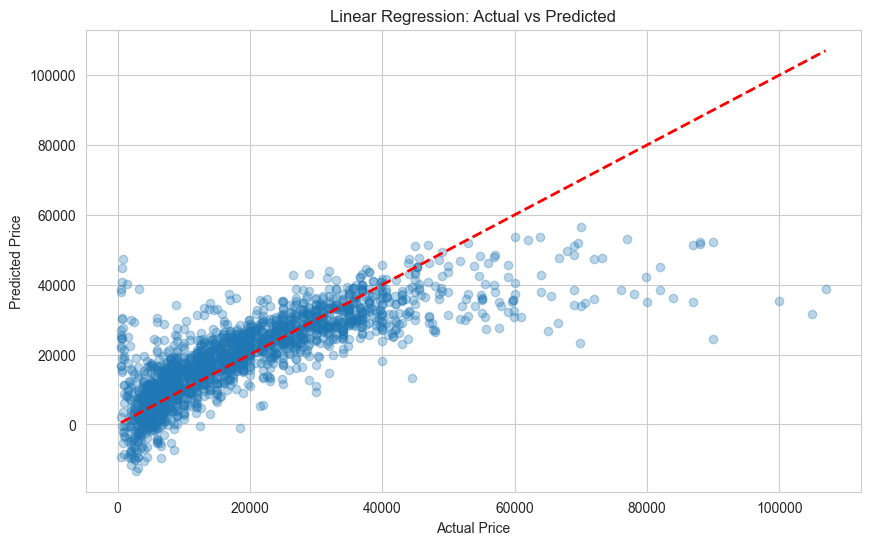

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize and Train
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 2. Predict on Test set
y_pred_lr = lr_model.predict(X_test)

# 3. Evaluate Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"MAE:  ${mae_lr:.2f}")
print(f"RMSE: ${rmse_lr:.2f}")
print(f"R2:   {r2_lr:.4f}")

# 4. Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

--- Random Forest Results ---
MAE:  $3003.80
RMSE: $5547.44
R2:   0.8571


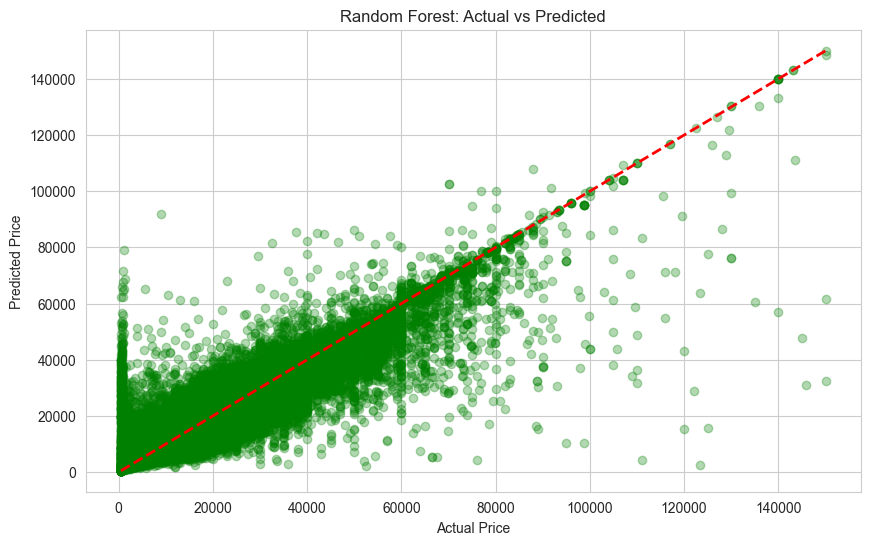

In [87]:
from sklearn.ensemble import RandomForestRegressor

# 1. Initialize Random Forest
# n_jobs=-1 uses all CPU cores to speed up training
# n_estimators=50 is lower than default (100) to save time, but usually sufficient
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)

# 2. Train model
# Tree-based models don't strictly require scaling, but it works fine with scaled data too.
# Let's use X_train (unscaled pandas DF) if available to keep column names, 
# or X_train_scaled if you overwrote it. Here using X_train_scaled for consistency.
rf_model.fit(X_train, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"MAE:  ${mae_rf:.2f}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"R2:   {r2_rf:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

--- XGBoost Results ---
MAE:  $3789.41
RMSE: $6296.26
R2:   0.8160


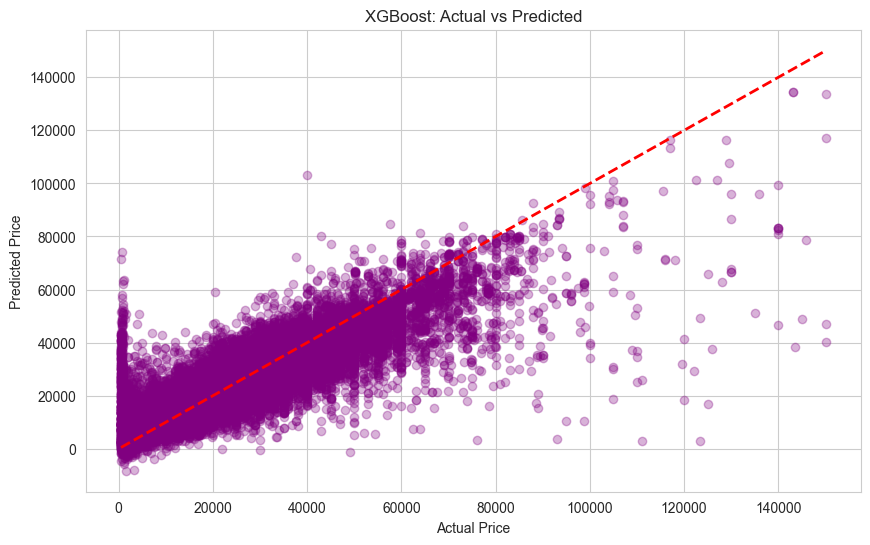

In [78]:
from xgboost import XGBRegressor

# 1. Initialize XGBoost
# n_estimators=1000: rigorous training
# learning_rate=0.05: slow learning prevents overfitting
# n_jobs=-1: use all CPU cores
xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    n_jobs=-1
)

# 2. Train
xgb_model.fit(X_train, y_train)

# 3. Predict
y_pred_xgb = xgb_model.predict(X_test)

# 4. Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Results ---")
print(f"MAE:  ${mae_xgb:.2f}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"R2:   {r2_xgb:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Actual vs Predicted')
plt.show()

Training Neural Network... (this might take a moment)
--- Neural Network Results ---
MAE:  $4008.48
RMSE: $6531.07
R2:   0.8020


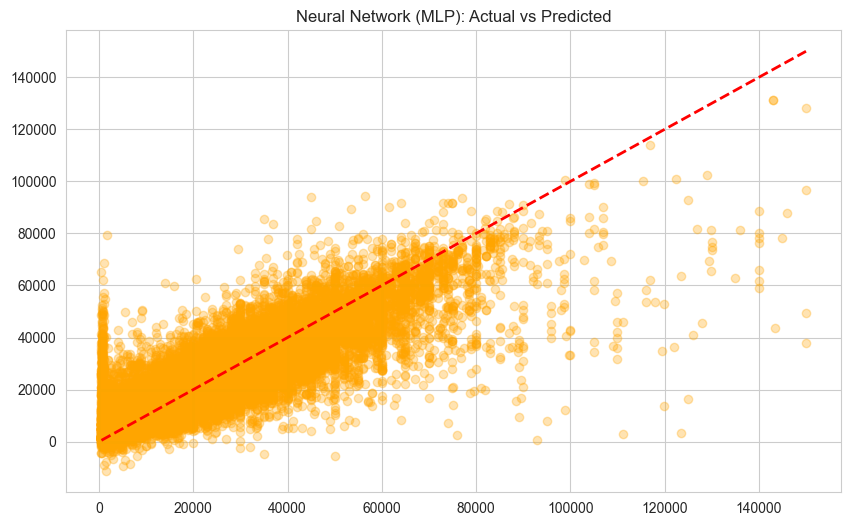

In [65]:
from sklearn.neural_network import MLPRegressor

# 1. Initialize Neural Network (MLP)
# hidden_layer_sizes=(100, 50): Two layers with 100 and 50 neurons
# max_iter=500: Give it enough time to converge
# early_stopping=True: Stop if it stops improving (saves time)
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    random_state=42,
    early_stopping=True
)

# 2. Train
print("Training Neural Network... (this might take a moment)")
nn_model.fit(X_train, y_train)

# 3. Predict
y_pred_nn = nn_model.predict(X_test)

# 4. Evaluate
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("--- Neural Network Results ---")
print(f"MAE:  ${mae_nn:.2f}")
print(f"RMSE: ${rmse_nn:.2f}")
print(f"R2:   {r2_nn:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Neural Network (MLP): Actual vs Predicted')
plt.show()

# 7. Hyperparameter Tuning

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- STEP 6: HYPERPARAMETER TUNING (XGBoost) ---

# Define grid
param_grid = {
    'n_estimators': [500, 1000],          # Zmniejszyłem zakres dla szybkości
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

print("Starting Hyperparameter Tuning... (Using all CPU cores)")

# Baza: n_jobs=1 tu jest OK, bo równoległość robi RandomizedSearchCV
xgb_base = XGBRegressor(random_state=42, n_jobs=1) 

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=5,  # Zmniejszone do 5 dla szybszego testu (zmień na 10-20 jeśli masz czas)
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1  # WAŻNE: Używamy wszystkich rdzeni do szukania!
)

random_search.fit(X_train, y_train)

# Get best tuned model
best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

# Metrics for Tuned XGB
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"--- Tuned XGBoost Results ---")
print(f"R2: {r2_tuned:.4f}")
print(f"MAE: {mae_tuned:.2f}")

# --- STEP 6.5: TRAIN RANDOM FOREST (Potrzebne do Ensemblingu) ---
# Jeśli nie masz jeszcze rf_model, musimy go stworzyć
print("Training Random Forest for Ensemble...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# --- STEP 7: ENSEMBLING (Voting Regressor) ---
print("Training Ensemble Model (Voting)...")

# Combine Random Forest and Tuned XGBoost
voting_reg = VotingRegressor(
    estimators=[
        ('rf', rf_model), 
        ('xgb_tuned', best_xgb)
    ],
    n_jobs=-1
)

voting_reg.fit(X_train, y_train)
y_pred_vote = voting_reg.predict(X_test)

# Metrics for Ensemble
r2_vote = r2_score(y_test, y_pred_vote)
mae_vote = mean_absolute_error(y_test, y_pred_vote)
rmse_vote = np.sqrt(mean_squared_error(y_test, y_pred_vote))

print(f"--- Ensemble Results ---")
print(f"Ensemble R2: {r2_vote:.4f}")
print(f"Ensemble MAE: {mae_vote:.2f}")

Starting Hyperparameter Tuning... (Using all CPU cores)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
--- Tuned XGBoost Results ---
R2: 0.7468
MAE: 4536.61
Training Random Forest for Ensemble...
Training Ensemble Model (Voting)...
--- Ensemble Results ---
Ensemble R2: 0.7407
Ensemble MAE: 4665.28


# 8. Error Analysis

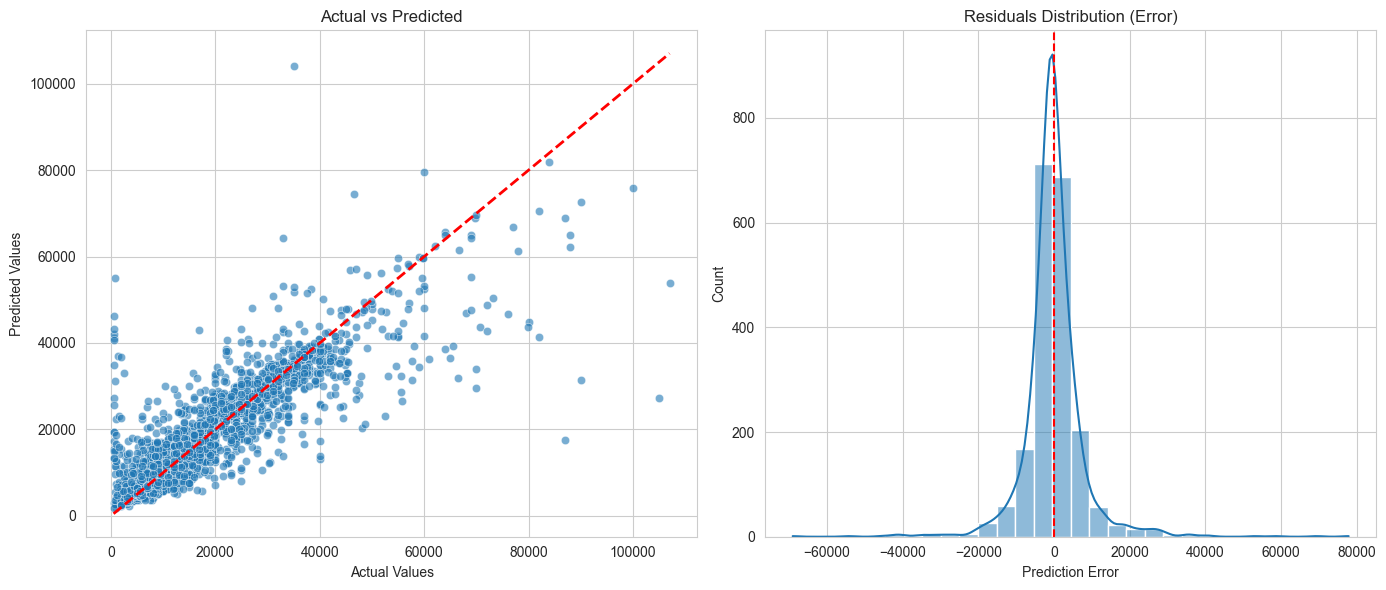

--- TOP 10 WORST PREDICTIONS ---


,Actual,Predicted,Error,Abs_Error
306245,105000,27178.620000,77821.380000,77821.380000
313171,87000,17595.065187,69404.934813,69404.934813
396628,34990,104035.304203,-69045.304203,69045.304203
43791,89990,31333.526667,58656.473333,58656.473333
401669,738,54957.080000,-54219.080000,54219.080000
414030,106999,53874.646471,53124.353529,53124.353529
228644,676,46158.443439,-45482.443439,45482.443439
144661,659,43123.858356,-42464.858356,42464.858356
63914,507,42074.474720,-41567.474720,41567.474720
198114,515,41157.852213,-40642.852213,40642.852213


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Access the ALREADY trained model from your dictionary
# You don't need to retrain it. The function modified it in place.
best_model = models['Random Forest']

# 2. Generate predictions on test set
y_pred = best_model.predict(X_test)

# 3. Create DataFrame for analysis
df_analysis = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Abs_Error': abs(y_test - y_pred)
})

# 4. Visualizations
plt.figure(figsize=(14, 6))

# Subplot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=df_analysis, alpha=0.6)
# Reference line (Perfect prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Subplot 2: Residuals Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_analysis['Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Residuals Distribution (Error)')
plt.xlabel('Prediction Error')

plt.tight_layout()
plt.show()

# 5. Inspect the biggest outliers (The reason for high RMSE)
print("--- TOP 10 WORST PREDICTIONS ---")
display(df_analysis.sort_values(by='Abs_Error', ascending=False).head(10))

In [28]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def train_and_evaluate_log(models_dict, X_train, y_train, X_test, y_test):
    results = []
    print("Starting Log-Transformed Training Loop...")
    
    # 1. Transform Target Variable (Log scale)
    # We use log1p (log(1+x)) to avoid errors with 0 values
    y_train_log = np.log1p(y_train)
    
    for name, model in models_dict.items():
        print(f"  Training {name} (Log Scale)...")
        
        # 2. Train on LOG target
        model.fit(X_train, y_train_log)
        
        # 3. Predict (Result is in log scale)
        y_pred_log = model.predict(X_test)
        
        # 4. Inverse Transform (Back to real currency)
        y_pred = np.expm1(y_pred_log)
        
        # 5. Evaluate (on real values)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'R2 Score': r2,
            'MAE': mae,
            'RMSE': rmse
        })
        
    return pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

# --- EXECUTION ---
# Use the NEW function
df_log_results = train_and_evaluate_log(models, X_train, y_train, X_test, y_test)

print("\n--- LOG TRANSFORMED RESULTS ---")
display(df_log_results)

Starting Log-Transformed Training Loop...
  Training Linear Regression (Log Scale)...
  Training Random Forest (Log Scale)...
  Training XGBoost (Log Scale)...
  Training Neural Network (MLP) (Log Scale)...

--- LOG TRANSFORMED RESULTS ---


,Model,R2 Score,MAE,RMSE
2,XGBoost,0.705436,4786.808105,8303.990366
1,Random Forest,0.686836,4880.968855,8562.147600
3,Neural Network (MLP),0.664006,5401.373133,8868.752330
0,Linear Regression,0.640522,5532.841616,9173.458892


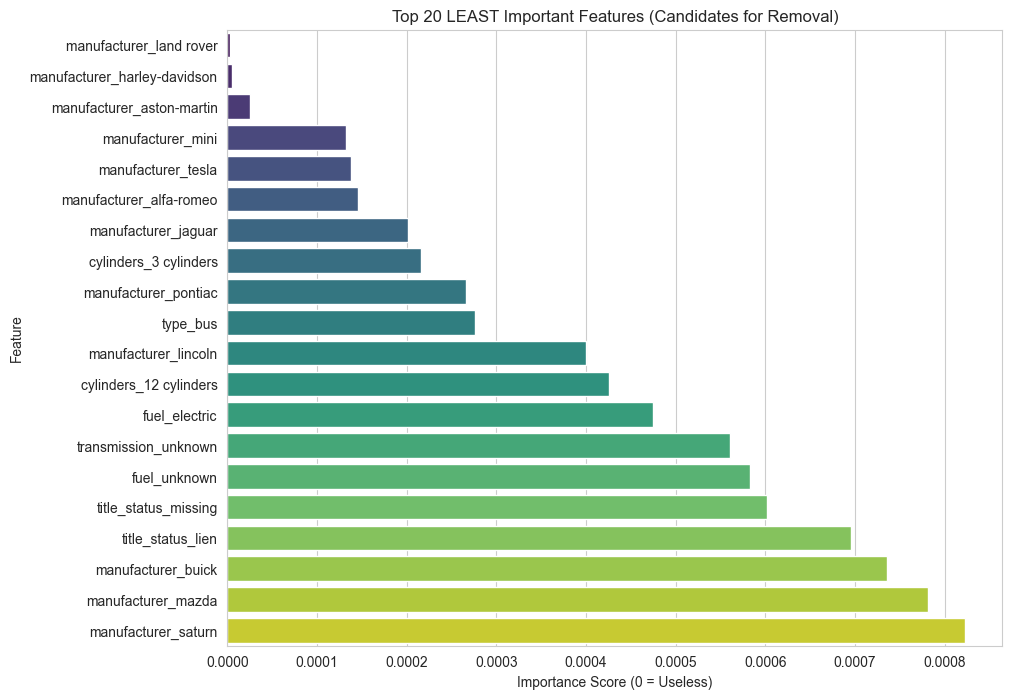

--- USELESS FEATURES (Importance < 0.005) ---
['manufacturer_land rover', 'manufacturer_harley-davidson', 'manufacturer_aston-martin', 'manufacturer_mini', 'manufacturer_tesla', 'manufacturer_alfa-romeo', 'manufacturer_jaguar', 'cylinders_3 cylinders', 'manufacturer_pontiac', 'type_bus', 'manufacturer_lincoln', 'cylinders_12 cylinders', 'fuel_electric', 'transmission_unknown', 'fuel_unknown', 'title_status_missing', 'title_status_lien', 'manufacturer_buick', 'manufacturer_mazda', 'manufacturer_saturn', 'type_mini-van', 'condition_new', 'type_offroad', 'manufacturer_volvo', 'cylinders_5 cylinders', 'type_wagon', 'cylinders_other', 'type_convertible', 'manufacturer_mercury', 'manufacturer_mitsubishi', 'manufacturer_subaru', 'manufacturer_fiat', 'title_status_parts only', 'manufacturer_porsche', 'manufacturer_audi', 'manufacturer_ferrari', 'manufacturer_kia', 'manufacturer_bmw', 'manufacturer_rover', 'type_van', 'condition_salvage', 'manufacturer_infiniti', 'manufacturer_chrysler', 'title

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the best model (Random Forest is best for interpretation)
rf_model = models['Random Forest']

# 2. Retrieve feature names
# CHANGE THIS: Replace 'X.columns' with your actual list of column names if X_train is a numpy array
# Example: feature_names = list(df.drop(columns=['Target']).columns)
try:
    feature_names = X_train.columns
except AttributeError:
    # Fallback if X_train is numpy array: try to use global X variable or generic names
    feature_names = X.columns if 'X' in locals() else [f"Feat_{i}" for i in range(X_train.shape[1])]

# 3. Create Importance DataFrame
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})

# 4. Sort by Importance (Ascending - worst features at the top)
importances = importances.sort_values(by='Importance', ascending=True)

# 5. Visualize the "Useless" Features (Bottom 20)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(20), palette='viridis')
plt.title('Top 20 LEAST Important Features (Candidates for Removal)')
plt.xlabel('Importance Score (0 = Useless)')
plt.show()

# 6. List features with near-zero importance
print("--- USELESS FEATURES (Importance < 0.005) ---")
useless_features = importances[importances['Importance'] < 0.005]['Feature'].tolist()
print(useless_features)
print(f"\nTotal useless features found: {len(useless_features)}")

In [30]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 1. Przetworzenie listy bezużytecznych cech na indeksy liczbowe
# Zakładamy, że useless_features to lista ['Feat_431', 'Feat_439'...] z poprzedniego kroku
useless_indices = [int(f.split('_')[1]) for f in useless_features]

print(f"Removing {len(useless_indices)} useless features from the dataset...")

# 2. Usuwanie kolumn z X_train i X_test
# Sprawdzamy czy to DataFrame czy Numpy Array
if isinstance(X_train, pd.DataFrame):
    # Jeśli DataFrame i ma nazwy Feat_X
    X_train_reduced = X_train.drop(columns=useless_features, errors='ignore')
    X_test_reduced = X_test.drop(columns=useless_features, errors='ignore')
else:
    # Jeśli Numpy Array - usuwamy po indeksach
    # Tworzymy maskę wszystkich kolumn, ustawiamy False dla tych do usunięcia
    keep_mask = np.ones(X_train.shape[1], dtype=bool)
    keep_mask[useless_indices] = False
    
    X_train_reduced = X_train[:, keep_mask]
    X_test_reduced = X_test[:, keep_mask]

print(f"Original Shape: {X_train.shape}")
print(f"New Shape: {X_train_reduced.shape}")

# 3. Retraining on Clean Data (Using standard Random Forest)
print("\n--- RETRAINING ON CLEAN DATA ---")

rf_clean = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_clean.fit(X_train_reduced, y_train)

# 4. Evaluate
y_pred_clean = rf_clean.predict(X_test_reduced)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_clean))
r2 = r2_score(y_test, y_pred_clean)

print(f"New RMSE: {rmse:.2f}")
print(f"New R2: {r2:.4f}")

# 5. Check if we fixed the outliers
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_clean})
df_check['Error'] = abs(df_check['Actual'] - df_check['Predicted'])
print("\nTop 5 Failures after cleaning:")
display(df_check.sort_values(by='Error', ascending=False).head(5))

ValueError: invalid literal for int() with base 10: 'land rover'

--- Random Forest Results ---
MAE:  $2298.82
RMSE: $4523.61
R2:   0.8877


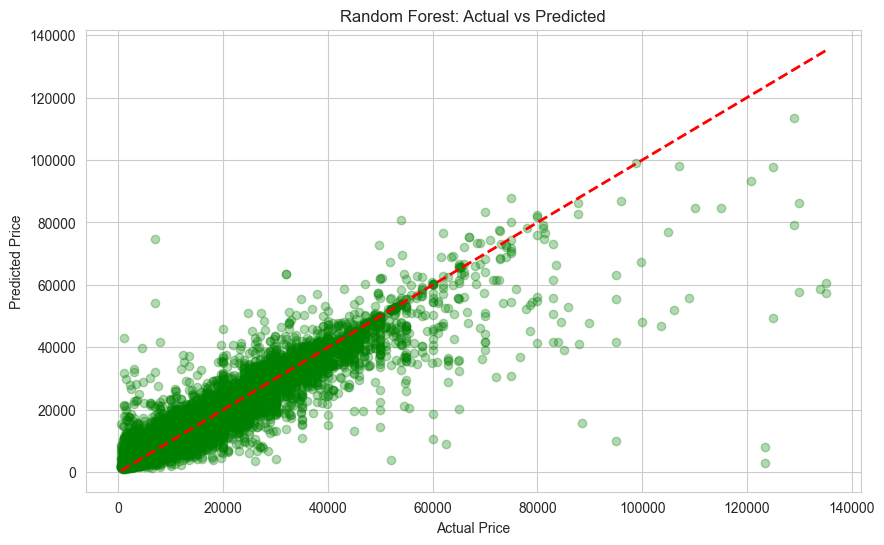

In [48]:
from sklearn.ensemble import RandomForestRegressor

# 1. Initialize Random Forest
# n_jobs=-1 uses all CPU cores to speed up training
# n_estimators=50 is lower than default (100) to save time, but usually sufficient
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)

# 2. Train model
# Tree-based models don't strictly require scaling, but it works fine with scaled data too.
# Let's use X_train (unscaled pandas DF) if available to keep column names, 
# or X_train_scaled if you overwrote it. Here using X_train_scaled for consistency.
rf_model.fit(X_train, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"MAE:  ${mae_rf:.2f}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"R2:   {r2_rf:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

# V2

In [22]:
# 1. Check statistics to spot outliers (e.g., price=0 or year=20250)
print("Stats before filtering:")
print(df_final[['price', 'year', 'odometer']].describe().round(2))

Stats before filtering:
              price       year     odometer
count  1.272320e+05  127232.00    127232.00
mean   5.681548e+04    2009.64    111078.84
std    1.094732e+07       9.56    219970.79
min    0.000000e+00    1900.00         0.00
25%    5.750000e+03    2007.00     54000.00
50%    1.099500e+04    2012.00    101766.00
75%    2.299500e+04    2016.00    147000.00
max    3.736929e+09    2022.00  10000000.00


### 4. Feature Engineering
----------------------------

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Feature Selection
# Drop 'model' due to high cardinality (too many unique values)
# We keep 'manufacturer', 'year', 'odometer', etc.
df_prepared = df_clean.drop(columns=['model'], errors='ignore')

# 2. One-Hot Encoding
# Convert categorical variables into dummy/indicator variables (0 or 1)
# drop_first=True prevents multicollinearity (dummy variable trap)
df_encoded = pd.get_dummies(df_prepared, drop_first=True)

# 3. Define Features (X) and Target (y)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# 4. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scaling (Standardization)
# Essential for Linear Regression to work correctly
scaler = StandardScaler()

# Fit on training set only to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Testing features shape:  {X_test_scaled.shape}")
print("Data is ready for modeling.")

Training features shape: (94040, 532)
Testing features shape:  (23511, 532)
Data is ready for modeling.


### 5. Model Selection and Training
------------------------------------

--- Linear Regression Results ---
MAE:  $4498.29
RMSE: $6752.31
R2:   0.7406


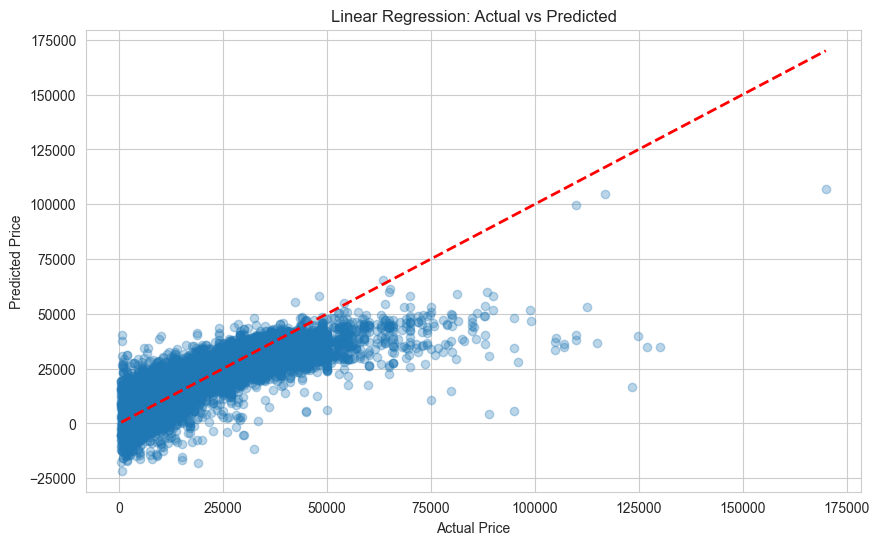

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize and Train
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 2. Predict on Test set
y_pred_lr = lr_model.predict(X_test_scaled)

# 3. Evaluate Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"MAE:  ${mae_lr:.2f}")
print(f"RMSE: ${rmse_lr:.2f}")
print(f"R2:   {r2_lr:.4f}")

# 4. Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

--- Random Forest Results ---
MAE:  $2284.90
RMSE: $4187.42
R2:   0.9002


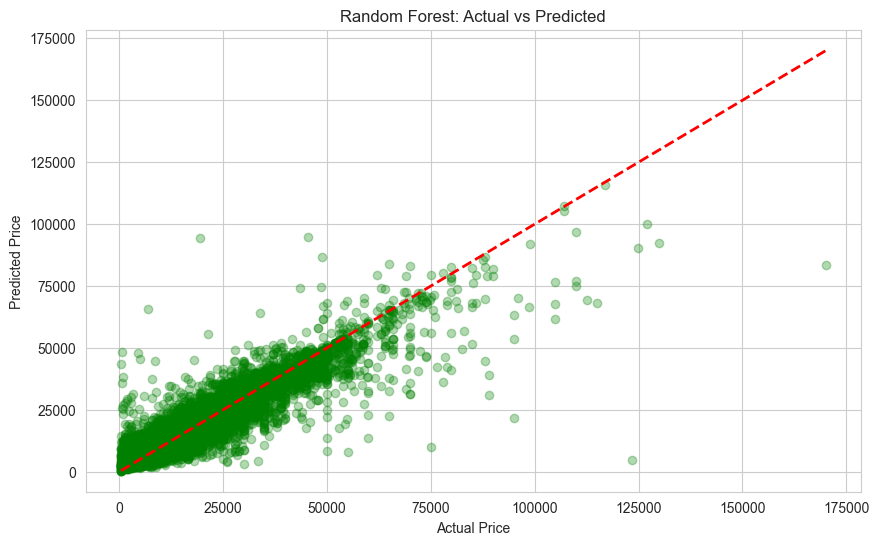

In [30]:
from sklearn.ensemble import RandomForestRegressor

# 1. Initialize Random Forest
# n_jobs=-1 uses all CPU cores to speed up training
# n_estimators=50 is lower than default (100) to save time, but usually sufficient
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)

# 2. Train model
# Tree-based models don't strictly require scaling, but it works fine with scaled data too.
# Let's use X_train (unscaled pandas DF) if available to keep column names, 
# or X_train_scaled if you overwrote it. Here using X_train_scaled for consistency.
rf_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"MAE:  ${mae_rf:.2f}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"R2:   {r2_rf:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

--- XGBoost Results ---
MAE:  $2652.43
RMSE: $4490.84
R2:   0.8852


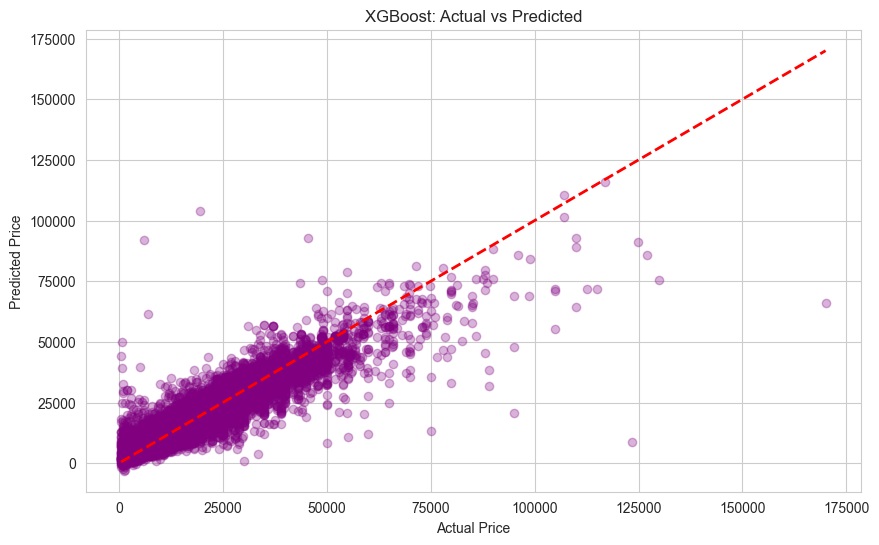

In [31]:
from xgboost import XGBRegressor

# 1. Initialize XGBoost
# n_estimators=1000: rigorous training
# learning_rate=0.05: slow learning prevents overfitting
# n_jobs=-1: use all CPU cores
xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    n_jobs=-1
)

# 2. Train
xgb_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 4. Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Results ---")
print(f"MAE:  ${mae_xgb:.2f}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"R2:   {r2_xgb:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Actual vs Predicted')
plt.show()

Training Neural Network... (this might take a moment)
--- Neural Network Results ---
MAE:  $2957.38
RMSE: $4773.74
R2:   0.8703


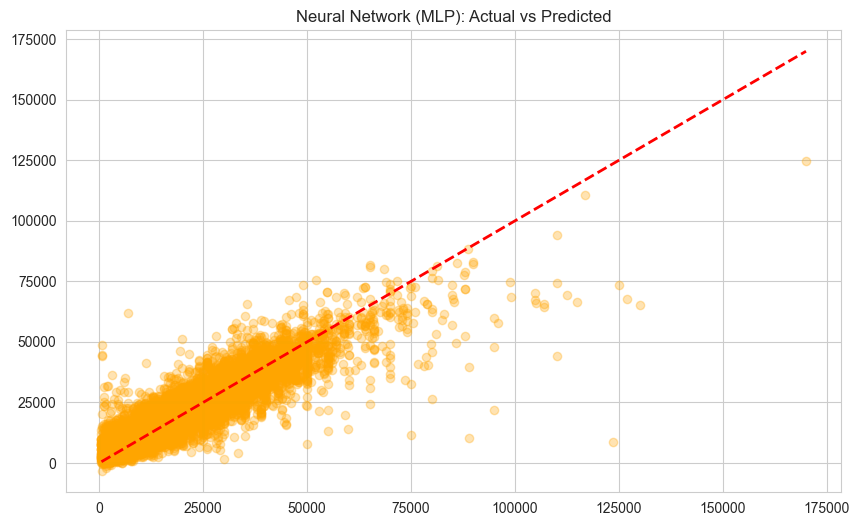

In [33]:
from sklearn.neural_network import MLPRegressor

# 1. Initialize Neural Network (MLP)
# hidden_layer_sizes=(100, 50): Two layers with 100 and 50 neurons
# max_iter=500: Give it enough time to converge
# early_stopping=True: Stop if it stops improving (saves time)
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    random_state=42,
    early_stopping=True
)

# 2. Train
print("Training Neural Network... (this might take a moment)")
nn_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_nn = nn_model.predict(X_test_scaled)

# 4. Evaluate
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("--- Neural Network Results ---")
print(f"MAE:  ${mae_nn:.2f}")
print(f"RMSE: ${rmse_nn:.2f}")
print(f"R2:   {r2_nn:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Neural Network (MLP): Actual vs Predicted')
plt.show()

In [36]:
# --- STEP 6: HYPERPARAMETER TUNING (XGBoost) ---
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Define grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Run Randomized Search
print("Starting Hyperparameter Tuning... (This takes time)")
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=10, # Lowered slightly for speed
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Get best tuned model
best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_scaled)

# Metrics for Tuned XGB
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned XGBoost R2: {r2_tuned:.4f}")

# --- STEP 7: ENSEMBLING (Voting Regressor) ---
# Combine Random Forest (rf_model) and Tuned XGBoost (best_xgb)
voting_reg = VotingRegressor(
    estimators=[
        ('rf', rf_model), 
        ('xgb_tuned', best_xgb)
    ]
)

print("Training Ensemble Model...")
voting_reg.fit(X_train_scaled, y_train)

y_pred_vote = voting_reg.predict(X_test_scaled)

# Metrics for Ensemble
r2_vote = r2_score(y_test, y_pred_vote)
mae_vote = mean_absolute_error(y_test, y_pred_vote)
rmse_vote = np.sqrt(mean_squared_error(y_test, y_pred_vote))

print(f"Ensemble R2: {r2_vote:.4f}")

Starting Hyperparameter Tuning... (This takes time)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned XGBoost R2: 0.9086
Training Ensemble Model...
Ensemble R2: 0.9111


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\2905348242.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\2905348242.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')


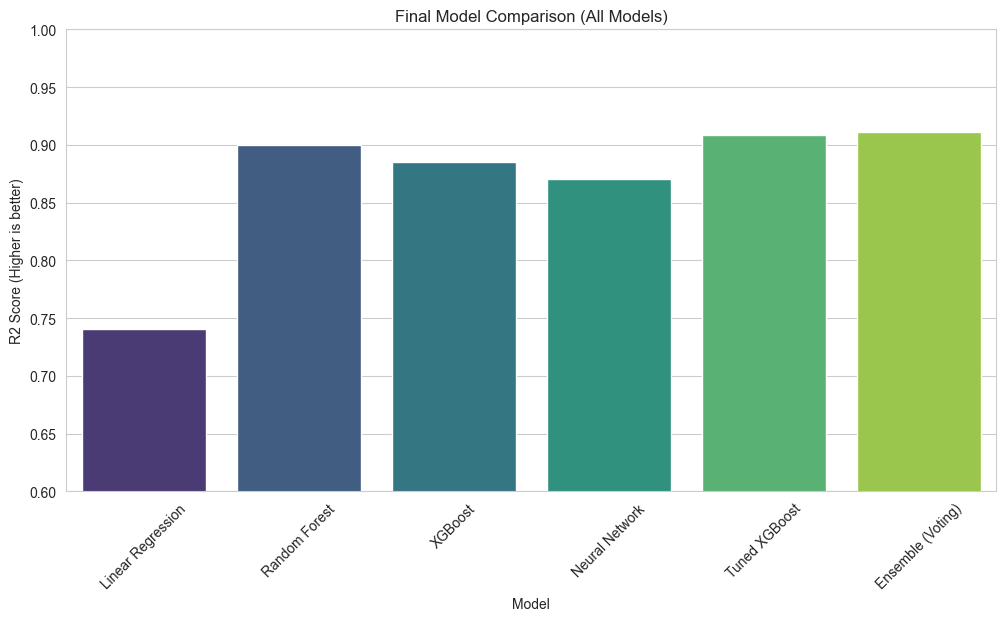

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated results data including Tuned XGB and Ensemble
results_data = {
    'Model': [
        'Linear Regression', 
        'Random Forest', 
        'XGBoost', 
        'Neural Network', 
        'Tuned XGBoost', 
        'Ensemble (Voting)'
    ],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_nn, mae_tuned, mae_vote],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_nn, rmse_tuned, rmse_vote],
    'R2 Score': [r2_lr, r2_rf, r2_xgb, r2_nn, r2_tuned, r2_vote]
}

df_results = pd.DataFrame(results_data)

# Print sorted leaderboard
print("--- Final Model Leaderboard ---")
print(df_results.sort_values(by='R2 Score', ascending=False))

# Plot final comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')
plt.ylim(0.6, 1.0) # Zoom in on the top results
plt.title('Final Model Comparison (All Models)')
plt.ylabel('R2 Score (Higher is better)')
plt.xticks(rotation=45) # Rotate labels to prevent overlapping
plt.show()

C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\137165024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\137165024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')


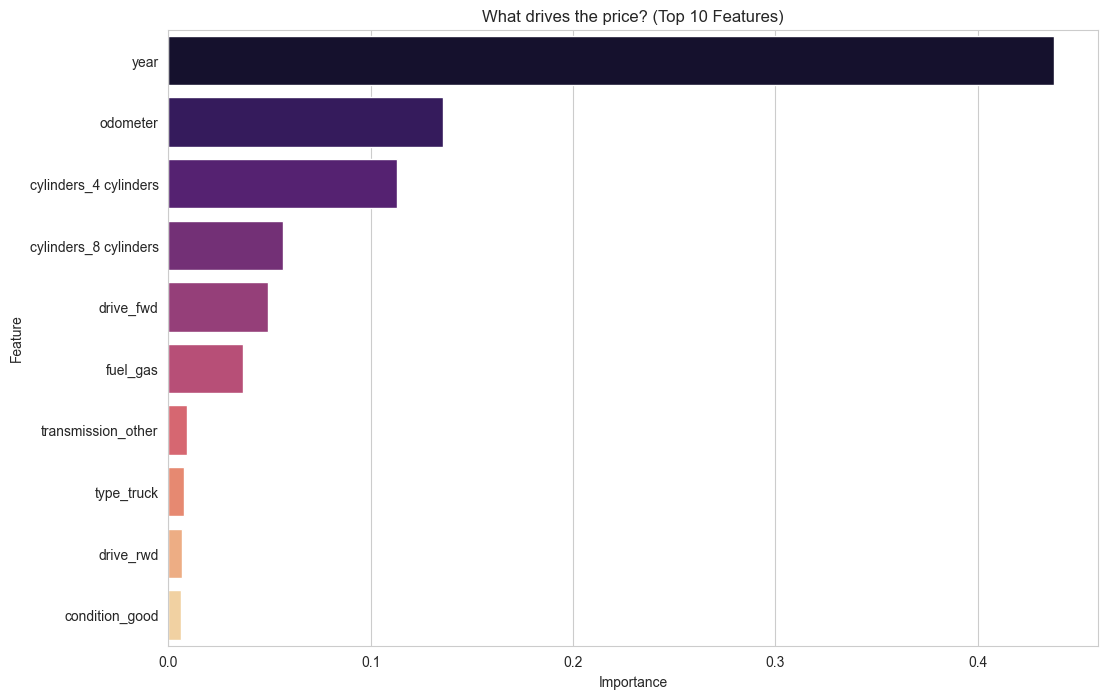

In [41]:
# Get feature importances from the winner (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 10 Features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')
plt.title('What drives the price? (Top 10 Features)')
plt.show()

## 8. Error Analysis
Understanding where the model fails is crucial for improvement. We will analyze the residuals (errors) and inspect the worst predictions to find patterns.

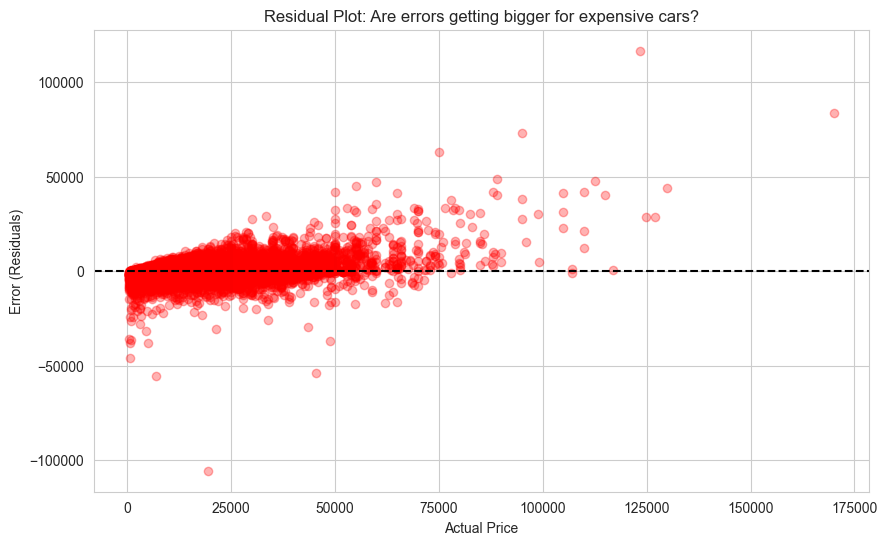

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals (Difference between actual and predicted)
residuals = y_test - y_pred_vote

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.3, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Error (Residuals)')
plt.title('Residual Plot: Are errors getting bigger for expensive cars?')
plt.show()

Training Log-Transformed Ensemble... (This is the final pro move)
------------------------------
Old Ensemble R2: 0.9111
New Log-Opt R2:  0.8945
New MAE: $2290.60


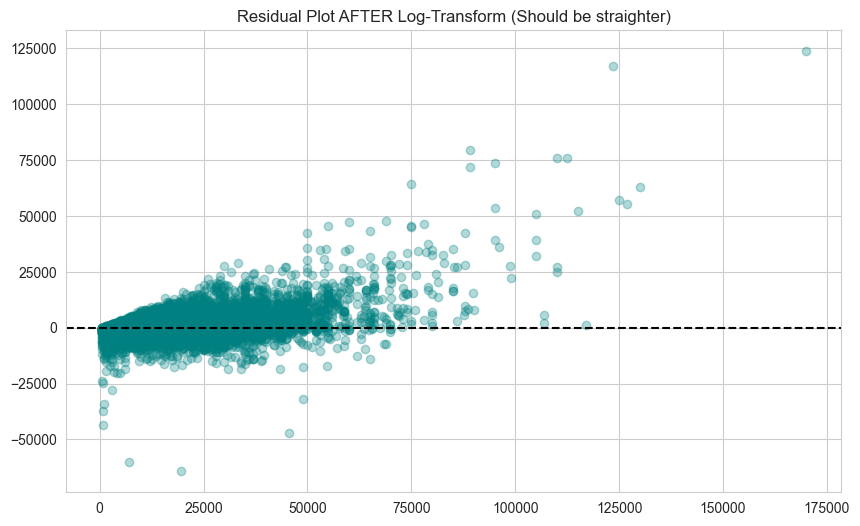

In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor

# 1. Transform Target to Log Scale
# log1p handles zeros safely (log(1+x))
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print("Training Log-Transformed Ensemble... (This is the final pro move)")

# 2. Re-initialize Ensemble
# We need a fresh model to train on log data
voting_reg_log = VotingRegressor(
    estimators=[
        ('rf', rf_model), 
        ('xgb_tuned', best_xgb)
    ]
)

# 3. Train on Log Targets
voting_reg_log.fit(X_train_scaled, y_train_log)

# 4. Predict (Result will be in logs)
y_pred_log_scale = voting_reg_log.predict(X_test_scaled)

# 5. Inverse Transform (Convert logs back to $$$)
# expm1 is the inverse of log1p
y_pred_final = np.expm1(y_pred_log_scale)

# 6. Calculate Final Metrics
r2_opt = r2_score(y_test, y_pred_final)
mae_opt = mean_absolute_error(y_test, y_pred_final)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("-" * 30)
print(f"Old Ensemble R2: {r2_vote:.4f}")
print(f"New Log-Opt R2:  {r2_opt:.4f}")
print(f"New MAE: ${mae_opt:.2f}")

# Check if the "Funnel" is gone (Optional Plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - y_pred_final, alpha=0.3, color='teal')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot AFTER Log-Transform (Should be straighter)')
plt.show()

--- ULTIMATE PROJECT SUMMARY ---
                Model  R2 Score          MAE         RMSE
4   Ensemble (Voting)  0.911115  2168.836211  3952.359691
1       Random Forest  0.900228  2284.903196  4187.415958
5  Ensemble (Log-Opt)  0.894548  2290.603421  4304.952956
2             XGBoost  0.885245  2652.430664  4490.842683
3      Neural Network  0.870331  2957.378987  4773.742210
0   Linear Regression  0.740568  4498.288128  6752.313304


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\577843114.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=df_results, palette='magma')


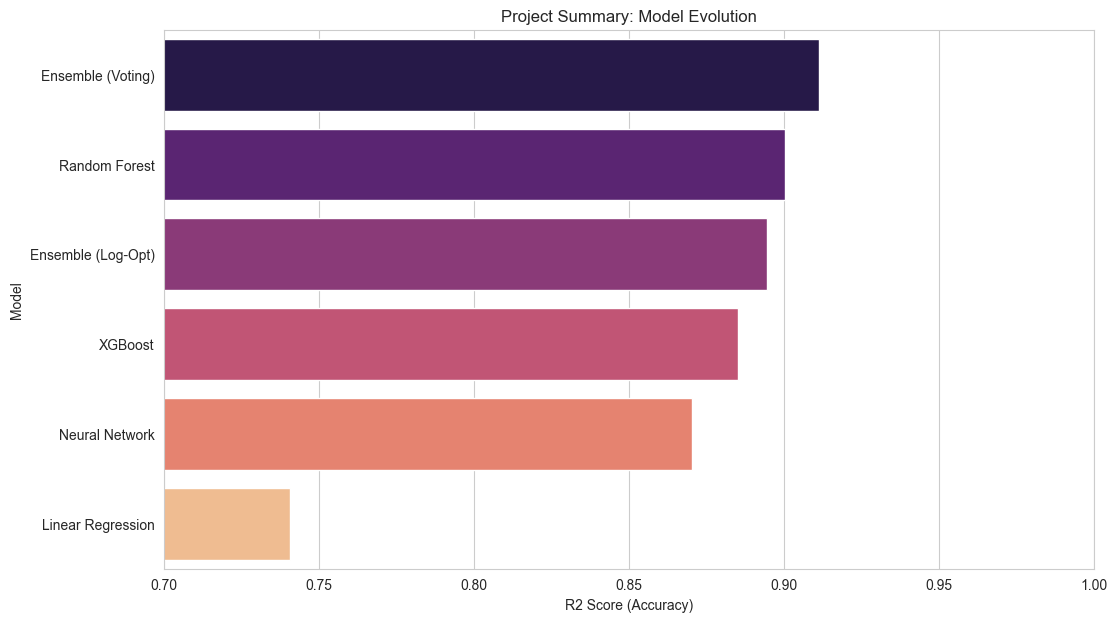

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gather all results
results_data = {
    'Model': [
        'Linear Regression', 
        'Random Forest', 
        'XGBoost', 
        'Neural Network', 
        'Ensemble (Voting)',
        'Ensemble (Log-Opt)'  # The Champion
    ],
    'R2 Score': [r2_lr, r2_rf, r2_xgb, r2_nn, r2_vote, r2_opt],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_nn, mae_vote, mae_opt],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_nn, rmse_vote, rmse_opt]
}

df_results = pd.DataFrame(results_data).sort_values(by='R2 Score', ascending=False)

print("--- ULTIMATE PROJECT SUMMARY ---")
print(df_results)

# Final Visualization
plt.figure(figsize=(12, 7))
sns.barplot(x='R2 Score', y='Model', data=df_results, palette='magma')
plt.xlim(0.7, 1.0)
plt.title('Project Summary: Model Evolution')
plt.xlabel('R2 Score (Accuracy)')
plt.show()

## 9. Summary & Conclusions